# TESS Sensitivity Analysis

__If you make use of this code, please cite Christ, C. N., Montet, B. T., & Fabrycky, D. C. 2018, arXiv:1810.02826__

The following code is used to determine how many and what types of planets TESS will be most sensitive to in the Kepler field for a given number of sectors

This analysis makes use of data from the NASA Exoplanet Archive as well as the following papers: Sullivan et al. 2015 and Christiansen et al. 2015

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy.special import erf
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
#Reading in Data frame the NASA Exoplanet Archive
df = pd.read_csv('exoplanet_archive_complete_version4.csv', skiprows=53)

In [4]:
#including only the following columns/data:
df = df.filter(items=['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_depth', 'koi_duration', 'koi_prad', 'koi_period', 'koi_period_err1', 'koi_time0bk', 'koi_time0bk_err1', 'koi_smass', 'koi_srad', 'koi_sma', 'koi_eccen', 'koi_incl', 'koi_longp'])

#adding in columns that we will later have data for
df['kep_contam_ratio'] = pd.Series(np.nan, index=df.index)
df['tess_contam_ratio'] = pd.Series(np.nan, index=df.index)
df['new_transit_depth'] = pd.Series(np.nan, index=df.index)
df['tess_magnitude'] = pd.Series(np.nan, index=df.index)
df['tot_noise'] = pd.Series(np.nan, index=df.index)
df['SNR1_1'] = pd.Series(np.nan, index=df.index)
df['SNR2_1'] = pd.Series(np.nan, index=df.index)
df['SNR1_2'] = pd.Series(np.nan, index=df.index)
df['SNR2_2'] = pd.Series(np.nan, index=df.index)

#falsely labeled planet
pos1 = np.where(df['kepid'] == 8110757)
df.at[6993, 'koi_disposition'] = 'FALSE POSITIVE'

#only using confirmed or candidate systems
df = df.loc[df['koi_disposition'].isin(['CONFIRMED', 'CANDIDATE'])]

In [5]:
#kepler contamination ratios
file1 = open('kepler_fov_search.txt')
df2 = pd.read_csv(file1, names=[ 'Kepler_ID', 'Crowding_season_0', 'Crowding_season_1', 'Crowding_season_2', 'Crowding_season_3'], skiprows=2)
file1.close()

In [6]:
#recording systems missing from the kepler contam file (should be none)
#taking median value of contam ratio and inputting in dataframe for kepler
missing_systems = []
for index, row in df.iterrows():
    idnum = row['kepid']
    loc = np.where(df2['Kepler_ID'] == idnum)
    if (len(loc[0]) == 0):
        missing_systems.append(idnum)
    else:
        rowdf2 = df2.iloc[loc[0]]
        crowding_array = np.array([rowdf2.iloc[0]['Crowding_season_0'], rowdf2.iloc[0]['Crowding_season_1'], 
                                   rowdf2.iloc[0]['Crowding_season_2'], rowdf2.iloc[0]['Crowding_season_3']])
        contam_val = np.nanmedian(crowding_array)
        df.at[index, 'kep_contam_ratio'] = contam_val 

In [7]:
#tess contamination ratio files 
df3 = pd.read_csv('MAST_Crossmatch_TIC.csv', skiprows=4)
df4 = pd.read_csv('MAST_Crossmatch_TIC_missing_Tmag.csv', skiprows=4)

In [8]:
'''
- recording missing systems from tess contam file (should be a fair amount) 
- search for those missing systems in another dataset and input the tess magnitude/contamratio into df
- if not missing, input tess mag/contamratio into df
- should have no missing_systems2 after running this code
'''
missing_systems2 = []
nan_systems = []
for index, row in df.iterrows():
    idnum = row['kepid']
    loc = np.where(df3['Kepler_ID'] == idnum)
    if (len(loc[0]) == 0):
        loc1 = np.where(df4['Kepler_ID'] == idnum)
        if (len(loc1) == 0):
            missing_systems2.append(idnum)
        else: 
            row2df = df4.iloc[(loc1[0][0])]
            missing_tmag = row2df['Tmag']
            missing_contamratio = row2df['contratio']
            if np.isnan(missing_contamratio):
                nan_systems.append(idnum)
                df.at[index, 'tess_magnitude'] = missing_tmag
                df.at[index, 'tess_contam_ratio'] = 0.0
            else:
                df.at[index, 'tess_magnitude'] = missing_tmag
                df.at[index, 'tess_contam_ratio'] = missing_contamratio
    else:
        rowdf2 = df3.iloc[loc[0]]
    
        contam_val = rowdf2.iloc[0]['contratio']
        tess_mag = rowdf2.iloc[0]['Tmag']
        
        if (np.isnan(contam_val) == True):
            nan_systems.append(idnum)
            contam_val = 0.0
            
        df.at[index, 'tess_contam_ratio'] = contam_val
        df.at[index, 'tess_magnitude'] = tess_mag

In [9]:
#print(missing_systems2)
#print('\n')
#print(nan_systems)

In [10]:
#taking the observed depth and dividing by the kepler contam ratio to find the true transit depth
#contaminating transit depts with the tess contam ratio (first have to convert t_contam_ratio to the same form as k_contam_ratio)#input new transit depth into df
for index, row in df.iterrows():
    koidepth = row['koi_depth'] 
    k_contam_ratio = row['kep_contam_ratio']
    t_contam_ratio = row['tess_contam_ratio']
    #koidepth = koidepth / k_contam_ratio
    t_contam_ratio = 1 / (1 + t_contam_ratio)
    koidepth = koidepth * t_contam_ratio  
    df.at[index, 'new_transit_depth'] = koidepth

In [11]:
#coming up with the equation that will convert a tess magnitude to total noise by using plot in Sullivan et al. 2015
for index, row in df.iterrows():
    mag = row['tess_magnitude']
    
    star_noise_log = 0.2235*mag + 0.0565
    sky_noise_log = 0.3347*mag - 1.6776
    read_noise_log = 0.3486*mag - 1.940
    syst_noise_log = np.log10(60)
    
    star_noise_r = 10**star_noise_log
    sky_noise_gn = 10**sky_noise_log
    read_noise_gy = 10**read_noise_log
    syst_noise_b = 10**syst_noise_log
    
    tot_noise = np.sqrt(star_noise_r**2 + sky_noise_gn**2 + read_noise_gy**2 + syst_noise_b**2)
    tot_noise *= np.sqrt(2)
    df.at[index, 'tot_noise'] = tot_noise 
#print(df)

In [12]:
'''
Function that calculates signal-to-noise ratio and inputs those SNR to our dataframe 

Input: 
    num_camp - the number of campaigns that TESS will observe the Kepler field (1=27.4 days, 2=54.8 days)
Output: 
    none, adds SNR to df
'''

def Calc_SNR(num_camp):
    for index, row in df.iterrows():
        signal = row['new_transit_depth']
        noise = row['tot_noise']
        tdur_hr = row['koi_duration']
        texp = 30 #minutes
        period = row['koi_period']
        tdur = tdur_hr * 60 
        
        #calculating the number of transits observed in a given period and number of campaigns
        num_transits = 27.4*num_camp / period
        N = int(num_transits)
        
        #the probability of detecting N+1 transits
        prob_nplus1 = num_transits%1
        df.at[index, 'prob_nplus1_'+ str(num_camp)] = prob_nplus1
        
        #SNR1 is the sig-noise ratio for detecting N transits
        SNR1 = (signal / noise) * np.sqrt(tdur / texp) * np.sqrt(N)
        df.at[index, 'SNR1_'+ str(num_camp)] = SNR1
    
        #SNR2 is the sig-noise tratio for detecting N+1 transits
        SNR2 = (signal / noise) * np.sqrt(tdur / texp) * np.sqrt(N+1)
        df.at[index, 'SNR2_'+ str(num_camp)] = SNR2

In [13]:
#calculates SNR for 1 or 2 campaigns (or specified value of campaigns (sectors), see Table 1 in Christ et al.)
for i in range(1, 3):
    Calc_SNR(i)

In [14]:
#function for converting noise to a probability of detection taken from Christiansen et al. 2015
def Phi(x,mu=0,sigma=1):
    t = erf((x-mu)/(sigma*sqrt(2)))
    return 0.5 + 0.5*t

In [15]:
#taking SNR for N and N+1 for both campaigns and converting them to probabilities of detection
#TESS has a 7.1 signal detection threshold, but best case scenario would be a 3 sigma signal detection threshold

for index, row in df.iterrows():
    snratio1_camp1 = row['SNR1_1']
    snratio2_camp1 = row['SNR2_1']
    snratio1_camp2 = row['SNR1_2']
    snratio2_camp2 = row['SNR2_2']
    prob_num_transits1 = row['prob_nplus1_1']
    prob_num_transits2 = row['prob_nplus1_2']
    
    #this line was used to find total SNR for harvard people
    df.at[index, 'total_SNR1'] = (snratio1_camp1*(1 - prob_num_transits1)) + (snratio2_camp1*(prob_num_transits1))
    df.at[index, 'total_SNR2'] = (snratio1_camp2*(1 - prob_num_transits2)) + (snratio2_camp2*(prob_num_transits2))
    
    period = row['koi_period']
    prob1_camp1 = Phi(snratio1_camp1, mu=3.0, sigma=1.0) #mu = signal detection threshold, using either 3 or 7.1
    prob2_camp1 = Phi(snratio2_camp1, mu=3.0, sigma=1.0)
    
    prob1_camp2 = Phi(snratio1_camp2, mu=3.0, sigma=1.0)
    prob2_camp2 = Phi(snratio2_camp2, mu=3.0, sigma=1.0)
    
    tot_prob_camp1 = prob1_camp1*(1 - prob_num_transits1) + prob2_camp1*(prob_num_transits1)
    tot_prob_camp2 = prob1_camp2*(1 - prob_num_transits2) + prob2_camp2*(prob_num_transits2)
    
    df.at[index, 'tot_prob_camp1'] = tot_prob_camp1
    df.at[index, 'tot_prob_camp2'] = tot_prob_camp2
    
#print(df)

In [16]:
#finding out how many of these prob vals are nan
nan_df = df['tot_prob_camp1'][~np.isfinite(df['tot_prob_camp1'])]
print(len(nan_df))

64


In [17]:
#finding any planets that have either a missing tess magnitude or depth
missing_tess_mag = []
missing_depth = []
for index, row in df.iterrows():
    if index in list(nan_df.index.values):
        if (np.isnan(df.loc[index]['koi_depth'])):
            missing_depth.append(df.loc[index]['kepid'])
        if (np.isnan(df.loc[index]['tess_magnitude'])):
            missing_tess_mag.append(df.loc[index]['kepid'])

In [18]:
print("missing tess mag", missing_tess_mag)
print("missing depth", missing_depth)
for kk in range(len(missing_tess_mag)):
    if missing_tess_mag[kk] in missing_depth:
        print(missing_tess_mag[kk])

missing tess mag []
missing depth [3447722, 10794087, 11336883, 7363829, 7199906, 5526717, 9411166, 10005788, 7033233, 4247991, 4247991, 5546761, 8872048, 8676038, 8676038, 9088780, 8478994, 8554498, 7296438, 2992634, 8525286, 9330740, 10319834, 10459749, 10554421, 10878117, 9229807, 11674709, 11818566, 11819396, 12350136, 8494783, 5471158, 9389245, 9727765, 10198662, 10414727, 11341164, 11656928, 11656928, 6946681, 4464394, 6697976, 11290515, 5092799, 5215508, 6368222, 7135549, 8815279, 9726452, 8953278, 10736489, 9932197, 3545626, 5552808, 5021432, 5633259, 7537660, 10079420, 5878506, 8682094, 9142714, 10407191, 8527297]


In [19]:
#if a planet is missing a depth, then remove it
for index, row in df.iterrows():
    if row['kepid'] in missing_depth:
        df = df.drop(labels=index)

In [20]:
#wrote this code to make sure all the planets with missing magnitudes and/or depths are erased from df
missing_tess_mag = []
missing_depth = []
for index, row in df.iterrows():
    if index in list(nan_df.index.values):
        print(df.loc[index])
        if (np.isnan(df.loc[index]['koi_depth'])):
            missing_depth.append(df.loc[index]['kepid'])
        if (np.isnan(df.loc[index]['tess_magnitude'])):
            missing_tess_mag.append(df.loc[index]['kepid'])
        print('\n')
        
print("missing tess mag", missing_tess_mag)
print("missing depth", missing_depth)

missing tess mag []
missing depth []


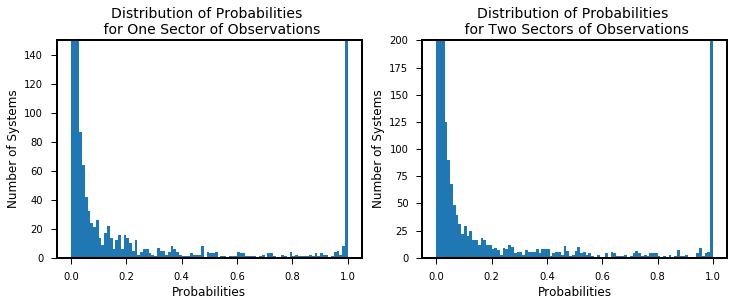

In [56]:
#showing the distribution of probabilities
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(df['tot_prob_camp1'], np.arange(0, 1.001, 0.01))
plt.title("Distribution of Probabilities \n for One Sector of Observations", fontsize=14)
plt.xlabel('Probabilities', fontsize=12); plt.ylabel('Number of Systems', fontsize=12)
plt.ylim(0, 150)

plt.subplot(122)
plt.hist(df['tot_prob_camp2'], np.arange(0, 1.001, 0.01))
plt.title("Distribution of Probabilities \n for Two Sectors of Observations", fontsize=14)
plt.xlabel('Probabilities', fontsize=12); plt.ylabel('Number of Systems', fontsize=12)
plt.ylim(0, 200)
plt.show()

In [ ]:
#the following systems were of interest to a research group 
'''
array3 = np.where(df['kepoi_name'] == 'K00500.02')
indexval3 = array3[0][0]
df.iloc[indexval3]

array4 = np.where(df['kepoi_name'] == 'K00500.03')
indexval4 = array4[0][0]
df.iloc[indexval4]

array5 = np.where(df['kepoi_name'] == 'K00500.04')
indexval5 = array5[0][0]
df.iloc[indexval5]

array6 = np.where(df['kepoi_name'] == 'K00500.05')
indexval6 = array6[0][0]
df.iloc[indexval6]

array1 = np.where(df['kepid'] == 1161345)
print(array1)
indexval = array1[0][0]
print(df.iloc[indexval])
'''

In [23]:
#probabilites of detection for KOI142, will need this info for the KOI-142 section
array1 = np.where(df['kepid'] == 5446285)
print(array1)
indexval = array1[0][0]
print(df.iloc[indexval])

(array([361]),)
kepid                    5446285
kepoi_name             K00142.01
kepler_name          Kepler-88 b
koi_disposition        CONFIRMED
koi_depth                   1479
koi_duration              3.6496
koi_prad                    3.93
koi_period               10.9161
koi_period_err1        4.875e-06
koi_time0bk              133.009
koi_time0bk_err1        0.000349
koi_smass                  1.051
koi_srad                   0.932
koi_sma                    0.098
koi_eccen                      0
koi_incl                   87.09
koi_longp                    NaN
kep_contam_ratio           0.985
tess_contam_ratio        1.07069
new_transit_depth        714.256
tess_magnitude            12.528
tot_noise                1182.35
SNR1_1                   2.30812
SNR2_1                   2.82686
SNR1_2                   3.64947
SNR2_2                   3.99779
prob_nplus1_1           0.510052
prob_nplus1_2          0.0201041
total_SNR1               2.57271
total_SNR2               3.

In [24]:
df_prob1 = df[df['tot_prob_camp1'] >= 0.5]
df_prob2 = df[df['tot_prob_camp2'] >= 0.5]

print("total number of detections in 1 sector", len(df_prob1))
print("total number of detections in 2 sectors", len(df_prob2))
print('\n')

confirmed_df_prob1 = df_prob1[df_prob1['koi_disposition'] != 'CANDIDATE']
candidate_df_prob1 = df_prob1[df_prob1['koi_disposition'] != 'CONFIRMED']
confirmed_df_prob2 = df_prob2[df_prob2['koi_disposition'] != 'CANDIDATE']
candidate_df_prob2 = df_prob2[df_prob2['koi_disposition'] != 'CONFIRMED']

#print statements are to see how many confirmed/candidate planets have a chance of being detected
print("confirmed (1 sector)", len(confirmed_df_prob1))
print("candidate (1 sector)", len(candidate_df_prob1))

print('\n')
print("confirmed (2 sectors)", len(confirmed_df_prob2))
print("candidate (2 sectors)", len(candidate_df_prob2))

#analyzing the red datapoint that has a small radius/period in below plot (this planet orbits a super small star)
unique_system = df_prob1[df_prob1['koi_period'] <= 1]

total number of detections in 1 sector 260
total number of detections in 2 sectors 380
confirmed (1 sector) 154
candidate (1 sector) 106


confirmed (2 sectors) 232
candidate (2 sectors) 148


In [25]:
#finding planets that will be detected that are less than 4 Earth radii
print("1 sector", len(df_prob1[df_prob1['koi_prad'] < 4])) 
print("2 sector", len(df_prob2[df_prob2['koi_prad'] < 4]))
print('\n')

print("confirmed, 1 sector", len(confirmed_df_prob1[confirmed_df_prob1['koi_prad'] < 4]))
print("candidate, 1 sector", len(candidate_df_prob1[candidate_df_prob1['koi_prad'] < 4]))
print('\n')

print("confirmed, 2 sector", len(confirmed_df_prob2[confirmed_df_prob2['koi_prad'] < 4]))
print("candidate, 2 sector", len(candidate_df_prob2[candidate_df_prob2['koi_prad'] < 4]))

1 sector 43
2 sector 107


confirmed, 1 sector 36
candidate, 1 sector 7


confirmed, 2 sector 89
candidate, 2 sector 18


In [ ]:
#looking at how many detectable nan_systems we have (nan systems being that they have a nan tess contam ratio)
detectable_nan_systems_camp1 = []
detectable_nan_systems_camp2 = []

for index, row in df_prob1.iterrows():
    if row['kepid'] in nan_systems:
        detectable_nan_systems_camp1.append(row['kepid'])

detectable_nan_systems_camp2 = []
for index, row in df_prob2.iterrows():
    if row['kepid'] in nan_systems:
        detectable_nan_systems_camp2.append(row['kepid'])

In [ ]:
'''
print(detectable_nan_systems_camp1)
print(detectable_nan_systems_camp2)
print(len(detectable_nan_systems_camp1))
print(len(detectable_nan_systems_camp2))
'''

# Data Visualization

The following code produces plots in order to better visualize/understand our results in the previous analysis

In [28]:
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rc('xtick.major', size=6, pad=8)
plt.rc('xtick.minor', size=4, pad=5)
plt.rc('ytick.major', size=6, pad=8)
plt.rc('ytick.minor', size=4, pad=5)

/Users/Callista/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


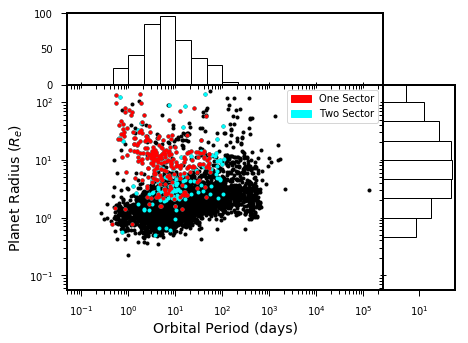

In [29]:
#making graph of all planets detectable by kepler vs what planets will be detectable in one or two sectors with TESS
fig, axes = plt.subplots(figsize=(7, 5))
axes.plot((df['koi_period']), (df['koi_prad']), 'k.')

plt.yscale('log')
plt.xscale('log')

axes.plot(df_prob2['koi_period'], df_prob2['koi_prad'], color='aqua', marker='.', linewidth=0)
axes.plot(df_prob1['koi_period'], df_prob1['koi_prad'], 'r.')

plt.xlabel('Orbital Period (days)', fontsize=14)
plt.ylabel(r'Planet Radius $(R_e)$', fontsize=14)

red_patch = mpatches.Patch(color='red', label='One Sector')
blue_patch = mpatches.Patch(color='aqua', label='Two Sector')
axes.legend(handles=[red_patch, blue_patch])

divider = make_axes_locatable(axes)
axHistx = divider.append_axes("top", 1.0, pad=0.0, sharex=axes)
axHisty = divider.append_axes("right", 1.0, pad=0.0, sharey=axes)

axHistx.xaxis.set_tick_params(labelbottom=False, direction='inout')
axHisty.yaxis.set_tick_params(labelleft=False, direction='inout')

logbins = np.geomspace(0.1, 1000, 13) 
axHistx.hist(df_prob2['koi_period'], bins=logbins, edgecolor='k', facecolor='w')

logbins2 = np.geomspace(0.1, 1000, 13) #df_prob2['koi_prad'].min(), df_prob2['koi_prad'].max(), 20)
axHisty.hist(df_prob2['koi_prad'], bins=logbins2, edgecolor='k', facecolor='w', orientation='horizontal', log=True)

plt.gcf().subplots_adjust(left=0.17, bottom=0.17, right=0.94, top=0.94, wspace=0.0, hspace=0.0)

plt.ylim(ymax=2*10**2)

#plt.savefig('period_vs_radius_confirm&cand3.0_poster.pdf', transparent=True)
plt.show()


In [30]:
#saving big df with all planets in it
df.to_csv('tess_sensitivity_inital_analysis7_sigma.csv')

In [31]:
#saving df_prob2 
df_prob2.to_csv('prob_of_detection_camp2.csv')

In [32]:
#making dataframe to include in paper as well as machine readable table
df_prob2 = pd.read_csv('prob_of_detection_camp2.csv')
sensdf_for_paper = df_prob2[['kepoi_name', 'kepler_name', 'tess_magnitude', 'new_transit_depth', 'tot_noise', 'total_SNR1', 'total_SNR2', 'tot_prob_camp1', 'tot_prob_camp2']]
sensdf_for_paper = sensdf_for_paper.sort_values(by=['kepoi_name'])
sensdf_for_paper = sensdf_for_paper.round({'tess_magnitude':2, 'new_transit_depth':0, 'tot_noise':0, 'total_SNR1':2, 'total_SNR2':2, 'tot_prob_camp1':3, 'tot_prob_camp2':3})
#sensdf_for_paper.to_csv('tess_sensitivity_final_table.csv', index = False, header=None)

# Extra Information

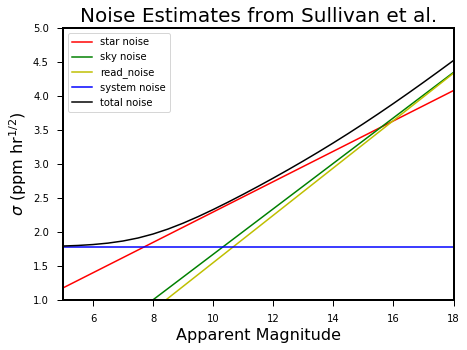

In [44]:
#recreating plot from sullivan et al. 2015 where the coefficients were used in the TESS Sensitivity Analysis
plt.figure(figsize=(7, 5))
x = np.arange(5, 20, .5)
syst_noise = np.zeros(shape=(30))
syst_noise += np.log10(60)
star_noise_log = 0.2235*x + 0.0565
sky_noise_log = 0.3347*x - 1.6776
read_noise_log = 0.3486*x - 1.940
syst_noise_log = np.log10(60)

star_noise_r = 10**star_noise_log
sky_noise_gn = 10**sky_noise_log
read_noise_gy = 10**read_noise_log
syst_noise_b = 10**syst_noise_log
    
tot_noise = np.sqrt(star_noise_r**2 + sky_noise_gn**2 + read_noise_gy**2 + syst_noise_b**2)
plt.plot(x, (0.2235*x + 0.0565), 'r', label='star noise')
plt.plot(x, (0.3347*x - 1.6776), 'g-', label='sky noise')
plt.plot(x, (0.3486*x - 1.940), 'y-', label='read_noise')
plt.plot(x, syst_noise, 'b', label='system noise')
plt.plot(x, np.log10(tot_noise), 'k', label='total noise')

plt.title('Noise Estimates from Sullivan et al.', fontsize=20)
plt.xlabel('Apparent Magnitude', fontsize=16)
plt.ylabel('$\\sigma$ (ppm hr$^{1/2}$)', fontsize=16)
plt.axis([5, 18, 1, 5])
plt.legend()
plt.show()